In [1]:
import itertools

import pandas as pd
import numpy as np
import numpy as np
import cvxpy as cp
import matplotlib.pyplot as plt

plt.style.use("seaborn")

# Question 1: Gradient and Newton methods

In [2]:
n = 100
m = 200
np.random.seed(1)
A = np.random.normal(size=(m, n))

Use cvxpy to get an accurate p_star which we'll use to plot error.

In [3]:
x = cp.Variable(n)
problem = cp.Problem(
    cp.Minimize(- cp.sum(cp.log(1 - A @ x)) - cp.sum(cp.log(1 - x ** 2)))
)

p_star = problem.solve()

Next we define our objective and calculate the first and second derivatives via the chain rule.

In [4]:
def objective(x):
    return -np.log(1 - A @ x).sum() - np.log(1 - x ** 2).sum()


def grad(x):
    return A.T @ (1 / (1 - A @ x)) + 2 * x / (1 - x ** 2)


# Note that actually 2 * x / (1 - x ** 2) is simply 1 / (1 - x) - 1 / (1 + x)
# which is a hell of a lot easier to differentiate (no product rule)
# so calculating the hessian is easier


def hess(x):
    return A.T @ np.diag(1 / (1 - A @ x) ** 2) @ A + np.diag(1 / (1 + x) ** 2 + 1 / (1 - x) ** 2)

In [5]:
MAX_ITERATIONS = 1000
DEF_ALPHA = 0.05
DEF_BETA = 0.8

def iterate(x, v, alpha=DEF_ALPHA, beta=DEF_BETA):
    val = objective(x)
    if np.linalg.norm(v) < 1e-4:
        return
    t = 1
    # Check we're in the domain of our objective
    while np.isnan(objective(x + t * v)):
        t *= beta
    # Then check the backtracking criteria
    while (objective(x + t * v) >= objective(x) + alpha * t * grad(x).T @ v):
        t *= beta
    return x + t * v

First, we use the gradient method by just taking the descent direction to be the negative gradient.

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 0, 'iteration')

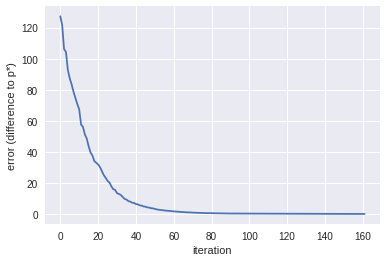

In [6]:
# Set x_0 to be all zeros, which is in the domain
x = np.zeros(n)

error = []

for _ in range(MAX_ITERATIONS):
    x = iterate(x, -grad(x))
    if x is None:
        break
    error.append(objective(x) - p_star)
    
error = np.array(error)

plt.plot(error[error > 0.01])
plt.gca().set_ylabel("error (difference to p*)") 
plt.gca().set_xlabel("iteration") 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  import sys
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in log
  


Text(0.5, 0, 'iteration')

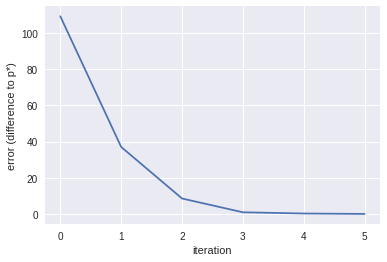

In [7]:
# Set x_0 to be all zeros, which is in the domain
x = np.zeros(n)

error = []

for _ in range(MAX_ITERATIONS):
    v = np.linalg.lstsq(-hess(x), grad(x))[0]
    x = iterate(x, v)
    if x is None:
        break
    error.append(objective(x) - p_star)
    
error = np.array(error)

plt.plot(error[error > 0.01])
plt.gca().set_ylabel("error (difference to p*)") 
plt.gca().set_xlabel("iteration") 

Wow, Newton's is _a lot_ faster here, solving it in 5 iterations instead of 160.

# Question 3: Flux balance analysis in systems biology 

### Convert Matlab data generation to numpy

In [8]:
S = np.array(
    [
        [1, 0, 0, 0, 0, 0],
        [-1, 1, 0, 0, 0, 0],
        [-1, 0, 1, 0, 0, 0],
        [0, -1, 0, 2, -1, 0],
        [0, 0, 0, 0, 1, 0],
        [0, -2, 1, 0, 0, 1],
        [0, 0, -1, 1, 0, 0],
        [0, 0, 0, 0, 0, -1],
        [0, 0, 0, -1, 0, 0],
    ]
).T

m, n = S.shape
vmax = np.array([10.10, 100, 5.90, 100, 3.70, 100, 100, 100, 100])

### Run optimisation

In [9]:
v = cp.Variable(n)
problem = cp.Problem(
    objective=cp.Maximize(v[-1]),
    constraints=[S @ v == 0, v >= 0, v <= vmax],
)

g_star = problem.solve()
g_star

13.54999999695169

Which of the reaction rate limits have nonzero optimal Lagrange multipliers? We just look at the dual to see
that R1, R3 and R5 are non zero.

In [10]:
dual = problem.constraints[2].dual_value
nonzero_lagrange = dual > 1e-8
nonzero_lagrange

array([ True, False,  True, False,  True, False, False, False, False])

And the largest is for R5, suggesting that increasing this reaction rate limit would have the biggest effect - ie, 
the maximal growth rate is most sensitive to R5.

In [11]:
dual[nonzero_lagrange]

array([0.5, 0.5, 1.5])

To find essential genes and synthetic lethals, we run the optimisation with each $v_i$ set to 0 and each $v_i, v_j$ 
pair set to 0 to find the ones such that the maximum growth rate is less than $0.2G^\star$.

In [12]:
essentials = []

for i in range(n):
    v = cp.Variable(n)
    
    vmax_clipped = vmax.copy()
    vmax_clipped[i] = 0
    
    problem = cp.Problem(
        objective=cp.Maximize(v[-1]),
        constraints=[S @ v == 0, v >= 0, v <= vmax_clipped],
    )

    if problem.solve() < 0.2 * g_star:
        essentials.append(i)
        
essentials = np.array(essentials)

In [13]:
synthetic_lethals = []

# Only look for combinations of genes that aren't themselves essential
# (otherwise trivially all combinations including an essential gene are synthetic lethals)
for i, j in itertools.combinations([i for i in range(n) if i not in essentials], r=2):
    v = cp.Variable(n)

    vmax_clipped = vmax.copy()
    vmax_clipped[i] = 0
    vmax_clipped[j] = 0

    problem = cp.Problem(
        objective=cp.Maximize(v[-1]),
        constraints=[S @ v == 0, v >= 0, v <= vmax_clipped],
    )

    if problem.solve() < 0.2 * g_star:
        synthetic_lethals.append((i, j))
        
synthetic_lethals = np.array(synthetic_lethals)

In [14]:
# Add 1 since the indices in the question are 1-based not 0-based
essentials += 1

synthetic_lethals += 1

In [15]:
print("Essential genes:")
display(essentials)
print("Synthetic lethals:")
display(synthetic_lethals)

Essential genes:


array([1, 9])

Synthetic lethals:


array([[2, 3],
       [2, 7],
       [4, 7],
       [5, 7]])

# Question 4: Online advertising displays

### Convert Matlab data generation to numpy


In [16]:
n = 100  # number of ads
m = 30  # number of contracts
T = 60  # number of periods

base_filepath = 'data/homework_8/online_advertising_displays'
# revenue from ad i in time period j
R_df = pd.read_csv(f'{base_filepath}/R.csv', header=None, prefix='R_')
R = np.array(R_df)
# R_df.head()
assert(R.shape == (n,T))

I_df = pd.read_csv(f'{base_filepath}/I.csv', header=None, prefix='I_')
I = np.array(I_df)
# I_df.head()
assert(I.shape == (T,1))
I = np.reshape( I , T )

A_contr_df = pd.read_csv(f'{base_filepath}/Acontr.csv', header=None, prefix='Acontr_')
Acontr = np.array(A_contr_df)
# A_contr_df.head()
assert(Acontr.shape == (n,m))

T_contr_df = pd.read_csv(f'{base_filepath}/Tcontr.csv', header=None, prefix='Tcontr_')
Tcontr = np.array(T_contr_df)
# T_contr_df.head()
assert(Tcontr.shape == (T,m))

p_df = pd.read_csv(f'{base_filepath}/p.csv', header=None, prefix='p_')
p = np.array(p_df)
# p_df.head()
assert(p.shape == (m,1))
p = np.reshape( p , m )

q_df = pd.read_csv(f'{base_filepath}/q.csv', header=None, prefix='q_')
q = np.array(q_df)
# q_df.head()
assert(q.shape == (m,1))
q = np.reshape( q , m )

### Run optimisation

In [17]:
N = cp.Variable((n, T))

revenue = cp.sum(cp.multiply(N, R))
penalty = p @ cp.maximum(q - cp.diag(Acontr.T @ N @ Tcontr), 0)

problem = cp.Problem(
    objective=cp.Maximize(revenue - penalty),
    constraints=[
        cp.sum(N, axis=0) == I,
        N >= 0,
    ]
)
problem.solve()

230.5660451657393

In [18]:
print(f"Optimal net profit: {problem.value:.2f}")
print(f"Associated optimal revenue: {revenue.value:.2f}")
print(f"Associated total penalty: {penalty.value:.2f}")

Optimal net profit: 230.57
Associated optimal revenue: 268.23
Associated total penalty: 37.67


What if we just display the ad in each timestep which has the highest revenue per impression? This is equivalent to
just maximising the profit, and ignoring the contracts.

In [19]:
N = cp.Variable((n, T))

revenue = cp.sum(cp.multiply(N, R))
penalty = p @ cp.maximum(q - cp.diag(Acontr.T @ N @ Tcontr), 0)

problem = cp.Problem(
    objective=cp.Maximize(revenue),
    constraints=[
        cp.sum(N, axis=0) == I,
        N >= 0,
    ]
)
problem.solve()

305.10171166804787

In [20]:
print(f"Greedy net profit: {revenue.value - penalty.value:.2f}")
print(f"Associated greedy revenue: {revenue.value:.2f}")
print(f"Associated total penalty: {penalty.value:.2f}")

Greedy net profit: 72.84
Associated greedy revenue: 305.10
Associated total penalty: 232.26
